# Лабораторная работа № 5. Подмена лица

Используйте файл requirements.txt, чтобы установить все необходимые библиотеки.

Необходимо использовать две видеозаписи на каждой из которых присутсвует человек, чье лицо необходимо заменять. Подмена работает в обе стороны.
На первом этапе вытащим по 500 лиц из каждой видеозаписи.
Убедитесь, что все лица вырезаны корректно.

## crop from video
dlib.get_frontal_face_detector

In [1]:
%run -i 'crop_from_video.py' --save_faces_path_a train/face_A --save_faces_path_b train/face_B --video_path_a video/putin_720_2018.mp4 --video_path_b video/putin_720_2019.mp4 --num_faces 1000

faces_process:   0%|          | 0/1000 [00:00<?, ?it/s]

Namespace(num_faces=1000, save_faces_path_a='train/face_A', save_faces_path_b='train/face_B', video_path_a='video/putin_720_2018.mp4', video_path_b='video/putin_720_2019.mp4')


KeyboardInterrupt: 

## autoencoder
### encoder

In [2]:
import torch
from models import Autoencoder
import torchsummary

In [4]:
model = Autoencoder()
torchsummary.summary(model.encoder, (3, 128, 128), batch_size=16, device='cpu')

RuntimeError: size mismatch, m1: [2 x 65536], m2: [16384 x 1024] at /tmp/pip-req-build-58y_cjjl/aten/src/TH/generic/THTensorMath.cpp:752

### decoder A

In [3]:
torchsummary.summary(model.decoder_A, (1024, 8, 8), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 2048, 8, 8]      18,876,416
         LeakyReLU-2           [32, 2048, 8, 8]               0
    _PixelShuffler-3          [32, 512, 16, 16]               0
            Conv2d-4         [32, 1024, 16, 16]       4,719,616
         LeakyReLU-5         [32, 1024, 16, 16]               0
    _PixelShuffler-6          [32, 256, 32, 32]               0
            Conv2d-7          [32, 512, 32, 32]       1,180,160
         LeakyReLU-8          [32, 512, 32, 32]               0
    _PixelShuffler-9          [32, 128, 64, 64]               0
           Conv2d-10            [32, 3, 64, 64]           9,603
          Sigmoid-11            [32, 3, 64, 64]               0
Total params: 24,785,795
Trainable params: 24,785,795
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 8.00
Fo

### decoder B

In [4]:
torchsummary.summary(model.decoder_B, (1024, 8, 8), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 2048, 8, 8]      18,876,416
         LeakyReLU-2           [32, 2048, 8, 8]               0
    _PixelShuffler-3          [32, 512, 16, 16]               0
            Conv2d-4         [32, 1024, 16, 16]       4,719,616
         LeakyReLU-5         [32, 1024, 16, 16]               0
    _PixelShuffler-6          [32, 256, 32, 32]               0
            Conv2d-7          [32, 512, 32, 32]       1,180,160
         LeakyReLU-8          [32, 512, 32, 32]               0
    _PixelShuffler-9          [32, 128, 64, 64]               0
           Conv2d-10            [32, 3, 64, 64]           9,603
          Sigmoid-11            [32, 3, 64, 64]               0
Total params: 24,785,795
Trainable params: 24,785,795
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 8.00
Fo

## augmentation

In [5]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)
# Аугментации данных. Позволяют разнообразить имеющийся набор данных.
augment = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Affine(
        scale=(0.95, 1.05),
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=(-10, 10),
#         shear=(-2, 2)
    )
], random_order=True)

# Изменения входного изображения
wrap = iaa.PiecewiseAffine(scale=0.025, nb_rows=5, nb_cols=5, )

# Изменение размера изображения
resize = iaa.Resize({"height": 128, "width": 128}, interpolation='nearest')

In [6]:
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib inline

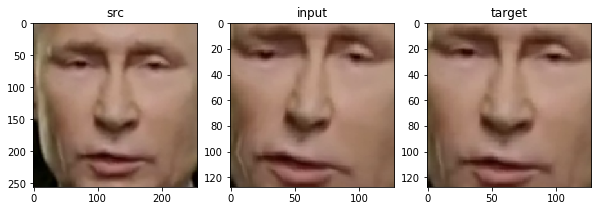

In [7]:
image = cv2.cvtColor(cv2.resize(cv2.imread('train/face_A/370.bmp'), (256,256)), cv2.COLOR_BGR2RGB)

img_aug = augment(image=image)

img_input = wrap(image = img_aug)

crop_percent = 0.07
img_target = img_aug[int(crop_percent * 256):-int(crop_percent * 256), int(crop_percent * 256):-int(crop_percent * 256)]
img_input = img_input[int(crop_percent * 256):-int(crop_percent * 256), int(crop_percent * 256):-int(crop_percent * 256)]

img_input = resize(image=img_input)
img_target = resize(image=img_target)

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.title('src')
plt.imshow(image)
plt.subplot(132)
plt.title('input')
plt.imshow(img_input)
plt.subplot(133)
plt.title('target')
plt.imshow(img_target)
plt.show()

In [9]:
import os
from tqdm import tqdm

def generator(path, num_images=10000, batch=16, transform=None, img_size=(128, 128)):

    pathes = [x.path for x in os.scandir(path) if x.name.endswith(".jpg") 
                 or x.name.endswith(".png") 
                 or x.name.endswith(".bmp")
                 or x.name.endswith(".JPG")]

    np.random.seed(0)
    np.random.shuffle(pathes)
    
    images = np.zeros((len(pathes), 256, 256, 3), dtype=float)
    for i, pth in enumerate(pathes):
        image = cv2.resize(cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB), (256, 256)) / 255
        images[i] = image    

    input_images = np.zeros((num_images, *img_size, 3), dtype=float)
    target_images = np.zeros((num_images, *img_size, 3), dtype=float)
    
    indexes = np.random.randint(0, high=len(images), size=num_images)
    for i, ind in tqdm(enumerate(indexes), total=num_images):
        target_image = images[ind]

        if augment:
            target_image = augment(image=target_image)

        input_image = target_image.copy()

        input_image = wrap(image=input_image)
        crop_percent = 0.13
        target_image = target_image[int(crop_percent * 256):-int(crop_percent * 256), int(crop_percent * 256):-int(crop_percent * 256), :]
        input_image = input_image[int(crop_percent * 256):-int(crop_percent * 256), int(crop_percent * 256):-int(crop_percent * 256), :]

        input_images[i] = resize(image=input_image)
        target_images[i] = resize(image=target_image)
        
    while True:
        indexes = np.random.randint(0, high=len(input_images), size=batch)
        yield torch.tensor(input_images[indexes].transpose((0,3,1,2))), torch.tensor(target_images[indexes].transpose((0,3,1,2)))

100%|██████████| 32/32 [00:01<00:00, 17.55it/s]


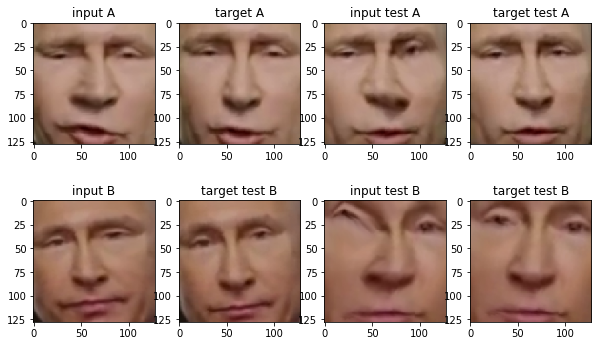

In [10]:
loader_A = generator("train/face_A", num_images=1000, batch = 16)
loader_B = generator("train/face_B", num_images=1000, batch = 16)
test_loader_A = generator("train/face_A", num_images=32, batch = 16)
test_loader_B = generator("train/face_B", num_images=32, batch = 16)

inp, trg = next(loader_A)

plt.figure(figsize=(10, 6))
i = 0
plt.subplot(241)
plt.title('input A')
plt.imshow(inp[i].numpy().transpose((1,2,0)))
plt.subplot(242)
plt.title('target A')
plt.imshow(trg[i].numpy().transpose(1,2,0))

inp, trg = next(test_loader_A)

plt.subplot(243)
plt.title('input test A')
plt.imshow(inp[i].numpy().transpose((1,2,0)))
plt.subplot(244)
plt.title('target test A')
plt.imshow(trg[i].numpy().transpose(1,2,0))

inp, trg = next(loader_B)

plt.subplot(245)
plt.title('input B')
plt.imshow(inp[i].numpy().transpose((1,2,0)))
plt.subplot(246)
plt.title('target test B')
plt.imshow(trg[i].numpy().transpose(1,2,0))

inp, trg = next(test_loader_B)

plt.subplot(247)
plt.title('input test B')
plt.imshow(inp[i].numpy().transpose((1,2,0)))
plt.subplot(248)
plt.title('target test B')
plt.imshow(trg[i].numpy().transpose(1,2,0))

In [11]:
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)

print('===> Try resume from checkpoint')
if os.path.isdir('checkpoint'):
    try:
        checkpoint = torch.load('./checkpoint/autoencoder.t7')
        model.load_state_dict(checkpoint['state'])
        start_epoch = checkpoint['epoch']
        print('===> Load last checkpoint data')
    except FileNotFoundError:
        print('Can\'t found autoencoder.t7')
else:
    start_epoch = 0
    print('===> Start from scratch')

criterion = nn.L1Loss()
optimizer_1 = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_A.parameters()}]
                         , lr=1e-4, betas=(0.5, 0.999))
optimizer_2 = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_B.parameters()}]
                         , lr=1e-4, betas=(0.5, 0.999))

===> Try resume from checkpoint
===> Start from scratch


In [12]:
%%time
print('Start training')

for epoch in range(start_epoch, 1000):
    model.train(True)
    input_A, target_A = next(loader_A)
    input_B, target_B = next(loader_B)

    input_A, target_A = input_A.to(device).float(), target_A.to(device).float()
    input_B, target_B = input_B.to(device).float(), target_B.to(device).float()

    optimizer_1.zero_grad()
    optimizer_2.zero_grad()


    res_A = model(input_A, 'A')
    res_B = model(input_B, 'B')

    loss1 = criterion(res_A, target_A)
    loss2 = criterion(res_B ,target_B)
    
    loss = loss1.item() + loss2.item()
    

    
    loss1.backward()
    loss2.backward()
    
    optimizer_1.step()
    optimizer_2.step()
    
    
    if epoch % 500 == 0:
        model.train(False)
        with torch.no_grad():
            input_A, target_A = next(test_loader_A)
            input_B, target_B = next(test_loader_B)

            input_A, target_A = input_A.to(device).float(), target_A.to(device).float()
            input_B, target_B = input_B.to(device).float(), target_B.to(device).float()

            res_A = model(input_A, 'A')
            res_B = model(input_B, 'B')

            loss1 = criterion(res_A, target_A)
            loss2 = criterion(res_B ,target_B)

        print('epoch: {}, val lossA:{}, lossB:{}'.format(epoch, loss1.item(), loss2.item()))
        test_A_ = target_A[0:16]
        test_B_ = target_B[0:16]
        test_A = target_A[0:16].detach().cpu().numpy().transpose((0,2,3,1))
        test_B = target_B[0:16].detach().cpu().numpy().transpose((0,2,3,1))
        
        print('===> Saving models...')
        state = {
            'state': model.state_dict(),
            'epoch': epoch
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/autoencoder.t7')
        
        #train/result.bmp

        figure_A = np.stack([
            test_A,
            model(test_A_, 'A').detach().cpu().numpy().transpose((0,2,3,1)),
            model(test_A_, 'B').detach().cpu().numpy().transpose((0,2,3,1)),
        ], axis=0)
        
        figure_B = np.stack([
            test_B,
            model(test_B_, 'B').detach().cpu().numpy().transpose((0,2,3,1)),
            model(test_B_, 'A').detach().cpu().numpy().transpose((0,2,3,1)),
        ], axis=0)
        figure = np.concatenate([figure_A, figure_B], axis=0)

        figure = np.concatenate([it for it in figure],axis = 2)

        figure = np.concatenate([it for it in figure],axis = 0)

        plt.imsave('train/result'+ str(epoch) +'.bmp', figure)
    
#     sheduler_1.step()
#     sheduler_2.step()

Start training


RuntimeError: size mismatch, m1: [16 x 131072], m2: [32768 x 2048] at /tmp/pip-req-build-58y_cjjl/aten/src/THC/generic/THCTensorMathBlas.cu:273

In [17]:
!nvidia-smi

OSError: [Errno 12] Cannot allocate memory

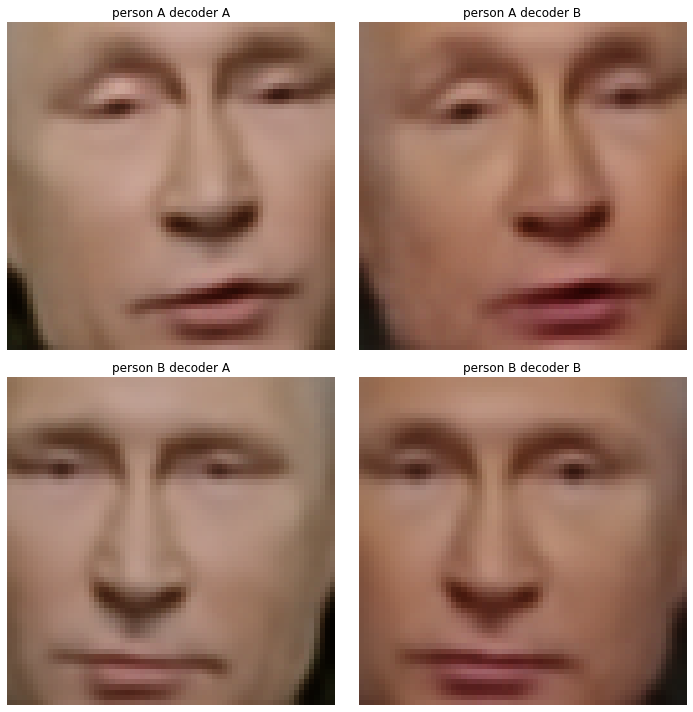

In [18]:
# model(test_A_, 'A').detach().cpu().numpy()[0].shape
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(model(test_A_, 'A').detach().cpu().numpy()[0].transpose((1,2,0)))
plt.axis('off')
plt.title('person A decoder A')
plt.subplot(222)
plt.imshow(model(test_A_, 'B').detach().cpu().numpy()[0].transpose((1,2,0)))
plt.axis('off')
plt.title('person A decoder B')
plt.subplot(223)
plt.imshow(model(test_B_, 'A').detach().cpu().numpy()[0].transpose((1,2,0)))
plt.axis('off')
plt.title('person B decoder A')
plt.subplot(224)
plt.imshow(model(test_B_, 'B').detach().cpu().numpy()[0].transpose((1,2,0)))
plt.axis('off')
plt.title('person B decoder B')
plt.tight_layout()
plt.show()

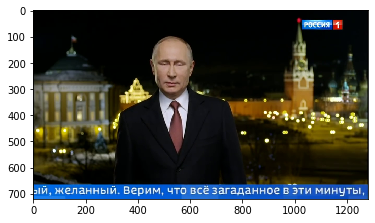

In [19]:
cap = cv2.VideoCapture('video/putin_720_2018.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 1600)
_, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

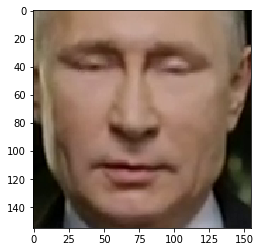

In [20]:
import dlib
detector = dlib.get_frontal_face_detector()
dets = detector(frame, 1)
if dets:
    left = dets[0].left()
    top = dets[0].top()
    right = dets[0].right()
    bot = dets[0].bottom()

croped_face = frame[top:bot, left:right]
plt.imshow(croped_face)

In [21]:
convert_face = np.expand_dims(cv2.resize(croped_face[int(0.10 * croped_face.shape[0]): int(- 0.10 * croped_face.shape[0]), int(0.10 * croped_face.shape[1]): int(- 0.10 * croped_face.shape[1])], (64,64)).transpose((2,0,1)), axis=0) / 255

result = model(torch.tensor(convert_face).to(device).float(), 'B')

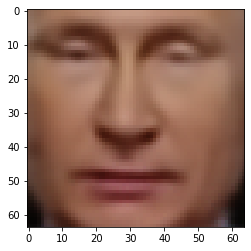

In [22]:
plt.imshow(np.squeeze(result.detach().cpu().numpy()).transpose((1,2,0)))